# Anna KaRNNa

In this notebook, we'll build a character-wise RNN trained on Anna Karenina, one of my all-time favorite books. It'll be able to generate new text based on the text from the book.

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn). Also, some information [here at r2rt](http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html) and from [Sherjil Ozair](https://github.com/sherjilozair/char-rnn-tensorflow) on GitHub. Below is the general architecture of the character-wise RNN.

<img src="assets/charseq.jpeg" width="500">
<br>

## [Any Questions seen in chinese blog:解读tensorflow之rnn](http://blog.csdn.net/mydear_11000/article/details/52414342)
<br>
<br>
<br>

In [7]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [8]:
# # open(): 'r' means reading
# # When you use the open function, it returns something called a file object. 
# with open('anna.txt', 'r') as f: 
#     text=f.read()
    
# vocab = set(text)
# # vocab: {'\n',' ','!','"','$','%','&',"'", ... ,'y','z'} all the characters exit in text

# # create character2index
# vocab_to_int = {c: i for i, c in enumerate(vocab)}
# # vocab_to_int: {'\n': 57,' ': 73,'!': 5,'"': 35,'$': 31, ...}

# #create index2character
# int_to_vocab = dict(enumerate(vocab))
# # int_to_vocab: {0: 'm',1: 'Z',2: '4',3: 'a',4: 'e',...}

# encoded = np.array([vocab_to_int[c] for c in text], dtype=np.int32)
with open('anna.txt', 'r') as f:
    text=f.read()
vocab = set(text)
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
encoded = np.array([vocab_to_int[c] for c in text], dtype=np.int32)

Let's check out the first 100 characters, make sure everything is peachy. According to the [American Book Review](http://americanbookreview.org/100bestlines.asp), this is the 6th best first line of a book ever.

In [9]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

And we can see the characters encoded as integers.

In [10]:
encoded[:100]

array([39, 82, 81, 33, 67, 75, 50, 80, 61,  3,  3,  3,  5, 81, 33, 33, 57,
       80, 34, 81, 74, 24, 18, 24, 75, 54, 80, 81, 50, 75, 80, 81, 18, 18,
       80, 81, 18, 24, 72, 75, 77, 80, 75,  2, 75, 50, 57, 80, 55,  0, 82,
       81, 33, 33, 57, 80, 34, 81, 74, 24, 18, 57, 80, 24, 54, 80, 55,  0,
       82, 81, 33, 33, 57, 80, 24,  0, 80, 24, 67, 54, 80, 46, 68,  0,  3,
       68, 81, 57, 23,  3,  3, 28,  2, 75, 50, 57, 67, 82, 24,  0])

Since the network is working with individual characters, it's similar to a classification problem in which we are trying to predict the next character from the previous text.  Here's how many 'classes' our network has to pick from.

In [11]:
len(vocab)

83

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>
We have our text encoded as integers as one long array in `encoded`. Let's create a function that will give us an iterator for our batches. I like using [generator functions](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) to do this. Then we can pass `encoded` into this function and get our batch generator.

The first thing we need to do is discard some of the text so we only have completely full batches. Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the number of batches we can make from some array `arr`, you divide the length of `arr` by the batch size. Once you know the number of batches and the batch size, you can get the total number of characters to keep.

After that, we need to split `arr` into $N$ sequences. You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences (`n_seqs` below), let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$ where $K$ is the number of batches.

Now that we have this array, we can iterate through it to get our batches. The idea is each batch is a $N \times M$ window on the array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. You'll usually see the first input character used as the last target character, so something like this:
```python
y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
```
where `x` is the input batch and `y` is the target batch.

The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.

> **Exercise:** Write the code for creating batches in the function below. The exercises in this notebook _will not be easy_. I've provided a notebook with solutions alongside this notebook. If you get stuck, checkout the solutions. The most important thing is that you don't copy and paste the code into here, **type out the solution code yourself.**

In [12]:
def get_batches(arr, n_seqs, batch_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence length(steps) per batch
    '''
    # Get the batch size and number of batches we can make
    batch_size = n_seqs*batch_steps # 一个batch的总字符数
    n_batches = len(arr)//batch_size # batch的个数
    
    # Keep only enough characters to make full batches
    arr = arr[:batch_size*n_batches] # 舍弃一些组不成一个batch的字符
    
    # Reshape into n_seqs rows
    arr = np.reshape(arr, [n_seqs,n_batches*batch_steps])
    
    for n in range(0, arr.shape[1], batch_steps):
        # The features
        x = arr[:n_seqs, n:n + batch_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        y[:,:-1], y[:,-1] = x[:,1:], x[:,0]
        yield x, y

# # 解法二:
# def get_batches(arr, n_seqs, n_steps):
#     '''Create a generator that returns batches of size
#        n_seqs x n_steps from arr.
       
#        Arguments
#        ---------
#        arr: Array you want to make batches from
#        n_seqs: Batch size, the number of sequences per batch
#        n_steps: Number of sequence steps per batch
#     '''
#     # Get the batch size and number of batches we can make
#     batch_size = n_seqs * n_steps
#     n_batches = len(arr)//batch_size
    
#     # Keep only enough characters to make full batches
#     arr = arr[:n_batches * batch_size]
    
#     # Reshape into n_seqs rows
#     arr = arr.reshape((n_seqs, -1))
    
#     for n in range(0, arr.shape[1], n_steps):
#         # The features
#         x = arr[:, n:n+n_steps]
#         # The targets, shifted by one
#         y = np.zeros_like(x)
#         y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
#         yield x, y

Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [13]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)
x[:,0]

array([39, 80,  2,  0, 80, 80, 82, 77, 67, 80])

In [14]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[39 82 81 33 67 75 50 80 61  3]
 [80 81 74 80  0 46 67 80 15 46]
 [ 2 24  0 23  3  3  4 69 75 54]
 [ 0 80 25 55 50 24  0 15 80 82]
 [80 24 67 80 24 54 62 80 54 24]
 [80 37 67 80 68 81 54  3 46  0]
 [82 75  0 80 38 46 74 75 80 34]
 [77 80 30 55 67 80  0 46 68 80]
 [67 80 24 54  0 19 67 23 80 42]
 [80 54 81 24 25 80 67 46 80 82]]

y
 [[82 81 33 67 75 50 80 61  3  3]
 [81 74 80  0 46 67 80 15 46 24]
 [24  0 23  3  3  4 69 75 54 62]
 [80 25 55 50 24  0 15 80 82 24]
 [24 67 80 24 54 62 80 54 24 50]
 [37 67 80 68 81 54  3 46  0 18]
 [75  0 80 38 46 74 75 80 34 46]
 [80 30 55 67 80  0 46 68 80 54]
 [80 24 54  0 19 67 23 80 42 82]
 [54 81 24 25 80 67 46 80 82 75]]


If you implemented `get_batches` correctly, the above output should look something like 
```
x
 [[55 63 69 22  6 76 45  5 16 35]
 [ 5 69  1  5 12 52  6  5 56 52]
 [48 29 12 61 35 35  8 64 76 78]
 [12  5 24 39 45 29 12 56  5 63]
 [ 5 29  6  5 29 78 28  5 78 29]
 [ 5 13  6  5 36 69 78 35 52 12]
 [63 76 12  5 18 52  1 76  5 58]
 [34  5 73 39  6  5 12 52 36  5]
 [ 6  5 29 78 12 79  6 61  5 59]
 [ 5 78 69 29 24  5  6 52  5 63]]

y
 [[63 69 22  6 76 45  5 16 35 35]
 [69  1  5 12 52  6  5 56 52 29]
 [29 12 61 35 35  8 64 76 78 28]
 [ 5 24 39 45 29 12 56  5 63 29]
 [29  6  5 29 78 28  5 78 29 45]
 [13  6  5 36 69 78 35 52 12 43]
 [76 12  5 18 52  1 76  5 58 52]
 [ 5 73 39  6  5 12 52 36  5 78]
 [ 5 29 78 12 79  6 61  5 59 63]
 [78 69 29 24  5  6 52  5 63 76]]
 ```
 although the exact numbers will be different. Check to make sure the data is shifted over one step for `y`.

## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`. This will be a scalar, that is a 0-D tensor. To make a scalar, you create a placeholder without giving it a size.

> **Exercise:** Create the input placeholders in the function below.

In [15]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32, shape=(batch_size,num_steps), name='inputs')
    targets = tf.placeholder(tf.int32, shape=(batch_size,num_steps), name='targets')
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    return inputs, targets, keep_prob

<img src="x.JPG">

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units) 
```
### [tf.contrib.rnn.BasicLSTMCell document](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicLSTMCell)

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 
```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob) 
```
### [Dropout](https://zhuanlan.zhihu.com/p/23178423)


You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. For example,

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```
### [rnn.MultiRNNCell](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell)
This might look a little weird if you know Python well because this will create **a list of the same `cell` object.** However, TensorFlow will create different weight matrices for all `cell` objects. Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```

> **Exercise:** Below, implement the `build_lstm` function to create these LSTM cells and the initial state.

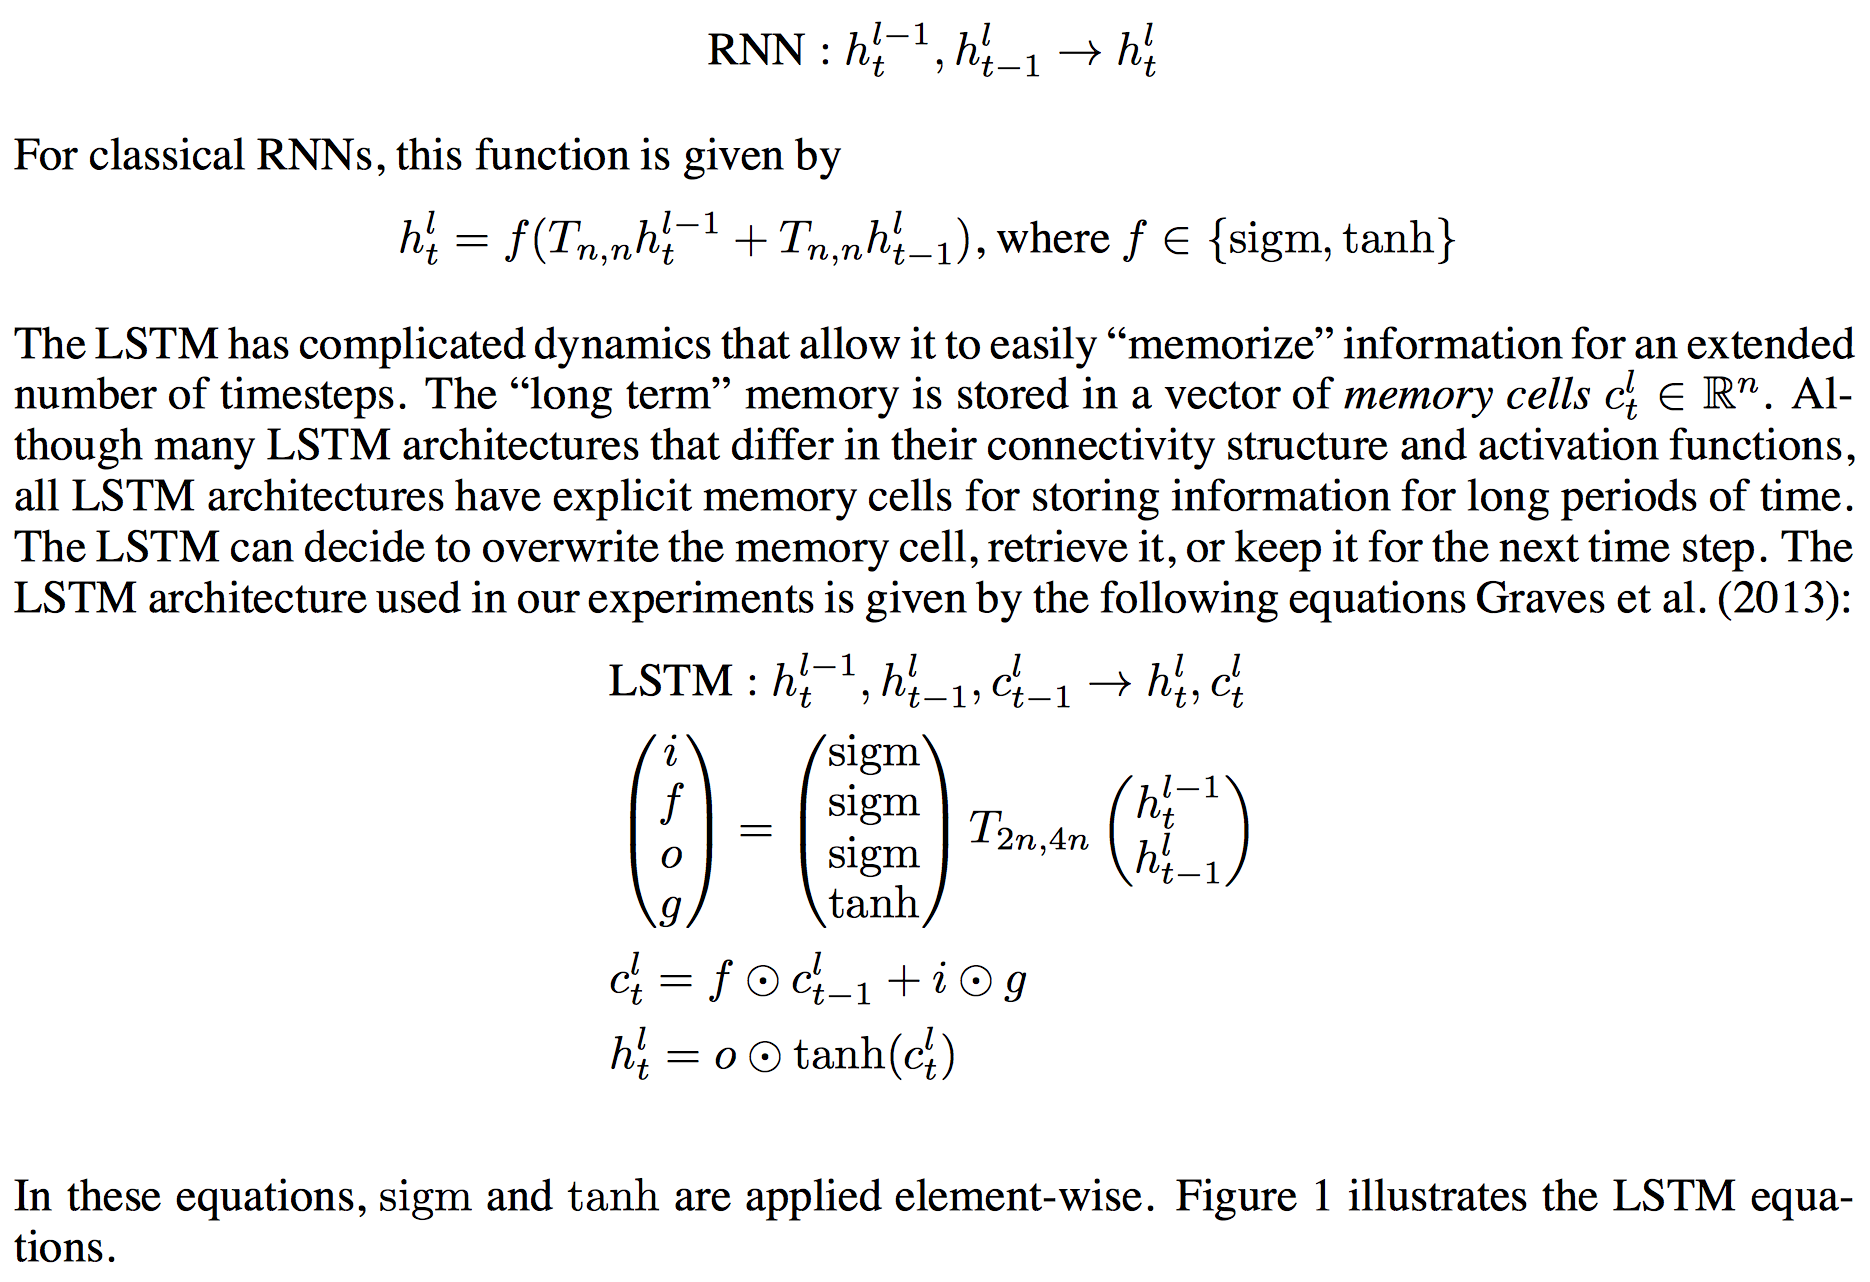
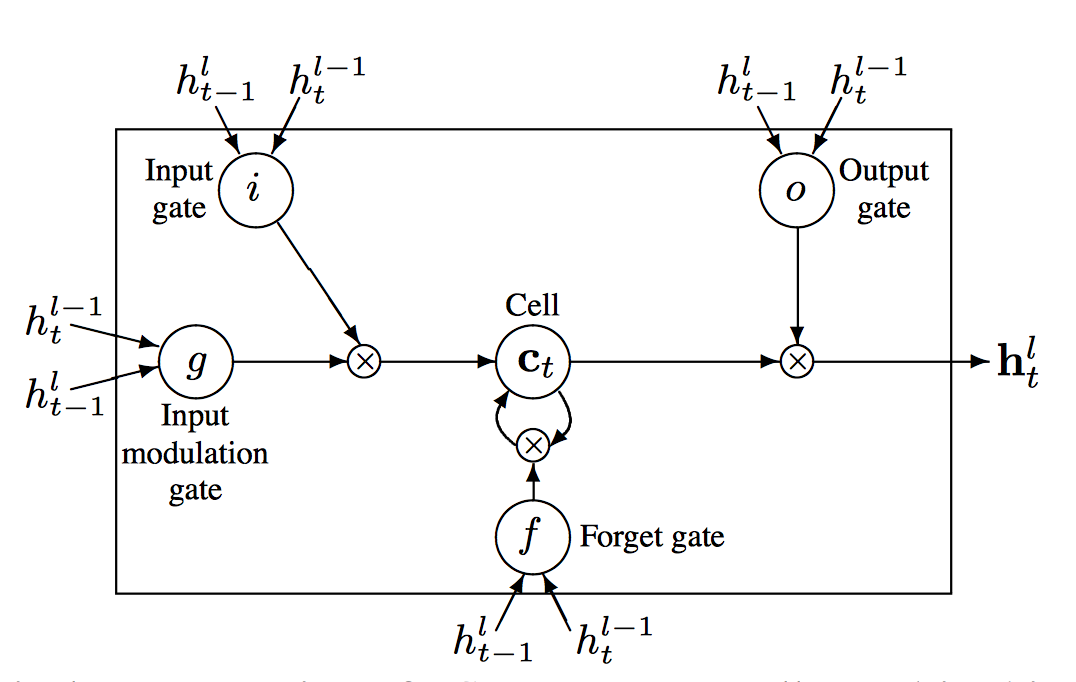

In [16]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability 用来给LSTMcell加Dropout
        lstm_size: Size of the hidden layers in the LSTM cells 用来初始化LSTM输出的dimension
        num_layers: Number of LSTM layers 用来堆叠多层LSTM网络
        batch_size: Batch size 用来生成initial_state, 此例中详见下图

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell outputs
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop for _ in range(num_layers)])
    
    # batch_size: 一个batch的总字符数
    initial_state = cell.zero_state(batch_size, tf.float32) 
    
    return cell, initial_state

# def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
#     ''' Build LSTM cell.
    
#         Arguments
#         ---------
#         keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
#         lstm_size: Size of the hidden layers in the LSTM cells
#         num_layers: Number of LSTM layers
#         batch_size: Batch size

#     '''
#     ### Build the LSTM Cell
#     # Use a basic LSTM cell
# #     lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
#     # Add dropout to the cell
#     drop = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(lstm_size), output_keep_prob=keep_prob)
    
#     # Stack up multiple LSTM layers, for deep learning
#     cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(lstm_size) for _ in range(num_layers)])
#     initial_state = cell.zero_state(batch_size, tf.float32)
    
#     return cell, initial_state

<img src="init_state.JPG">

### RNN Output

Here we'll create the output layer. We need to connect the output of the RNN cells to a full connected layer with a softmax output. The softmax output gives us a probability distribution we can use to predict the next character, so we want this layer to have size $C$, the number of classes/characters we have in our text.

If our input has batch size $N$, number of steps $M$, and the hidden layer has $L$ hidden units, then the output is a 3D tensor with size $N \times M \times L$. The output of each LSTM cell has size $L$, we have $M$ of them, one for each sequence step, and we have $N$ sequences. So the total size is $N \times M \times L$. 

We are using the same fully connected layer, the same weights, for each of the outputs. Then, to make things easier, we should reshape the outputs into a 2D tensor with shape $(M * N) \times L$. That is, one row for each sequence and step, where the values of each row are the output from the LSTM cells. We get the LSTM output as a list, `lstm_output`. First we need to concatenate this whole list into one array with [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat). Then, reshape it (with `tf.reshape`) to size $(M * N) \times L$.

One we have the outputs reshaped, we can do the matrix multiplication with the weights. We need to wrap the weight and bias variables in a variable scope with [tf.variable_scope(scope_name)](https://www.tensorflow.org/api_docs/python/tf/variable_scope) because there are weights being created in the LSTM cells. TensorFlow will throw an error if the weights created here have the same names as the weights created in the LSTM cells, which they will be default. To avoid this, we wrap the variables in a variable scope so we can give them unique names.

> **Exercise:** Implement the output layer in the function below.

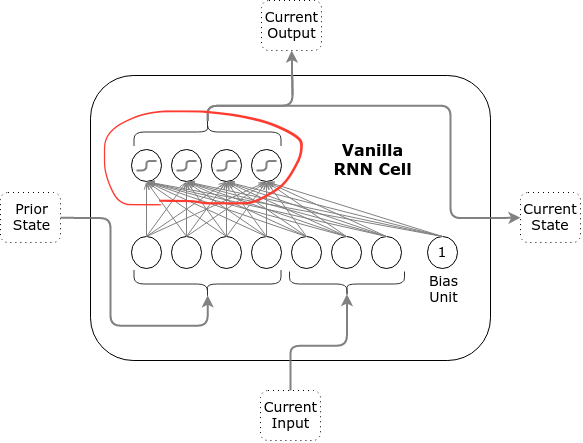

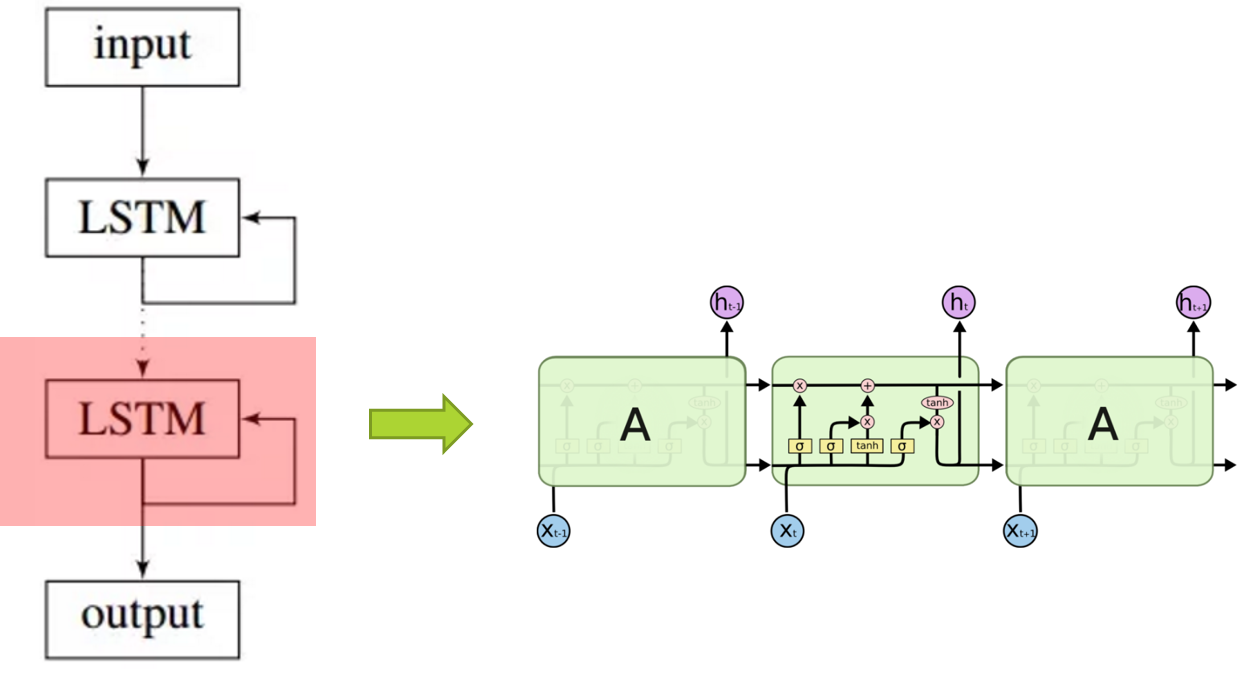

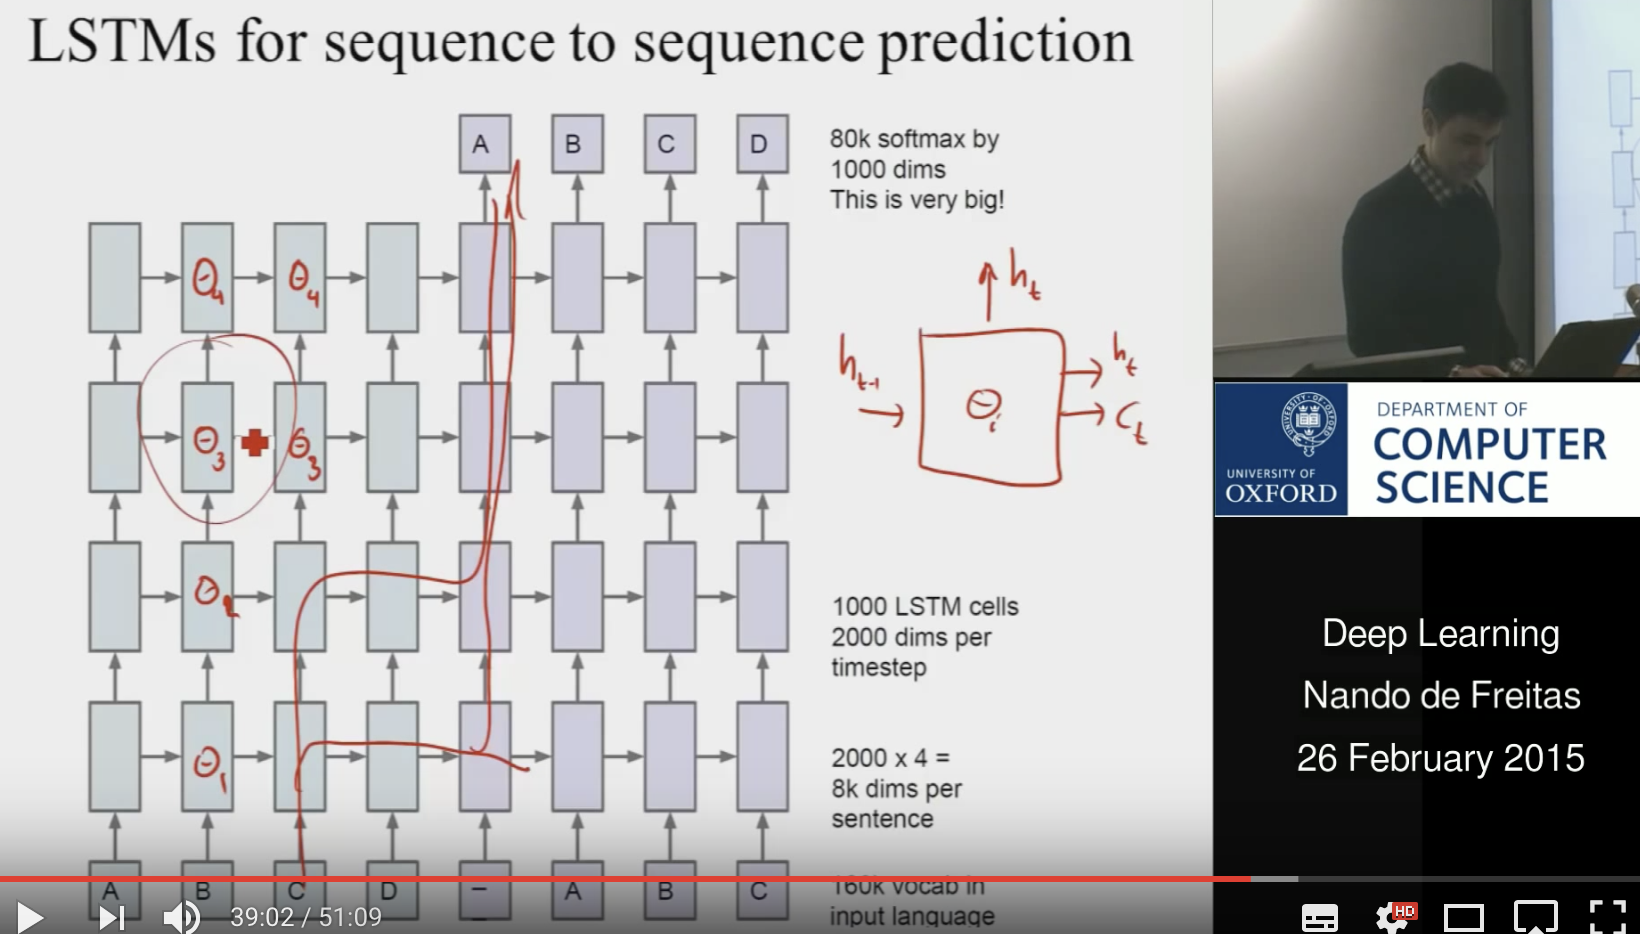

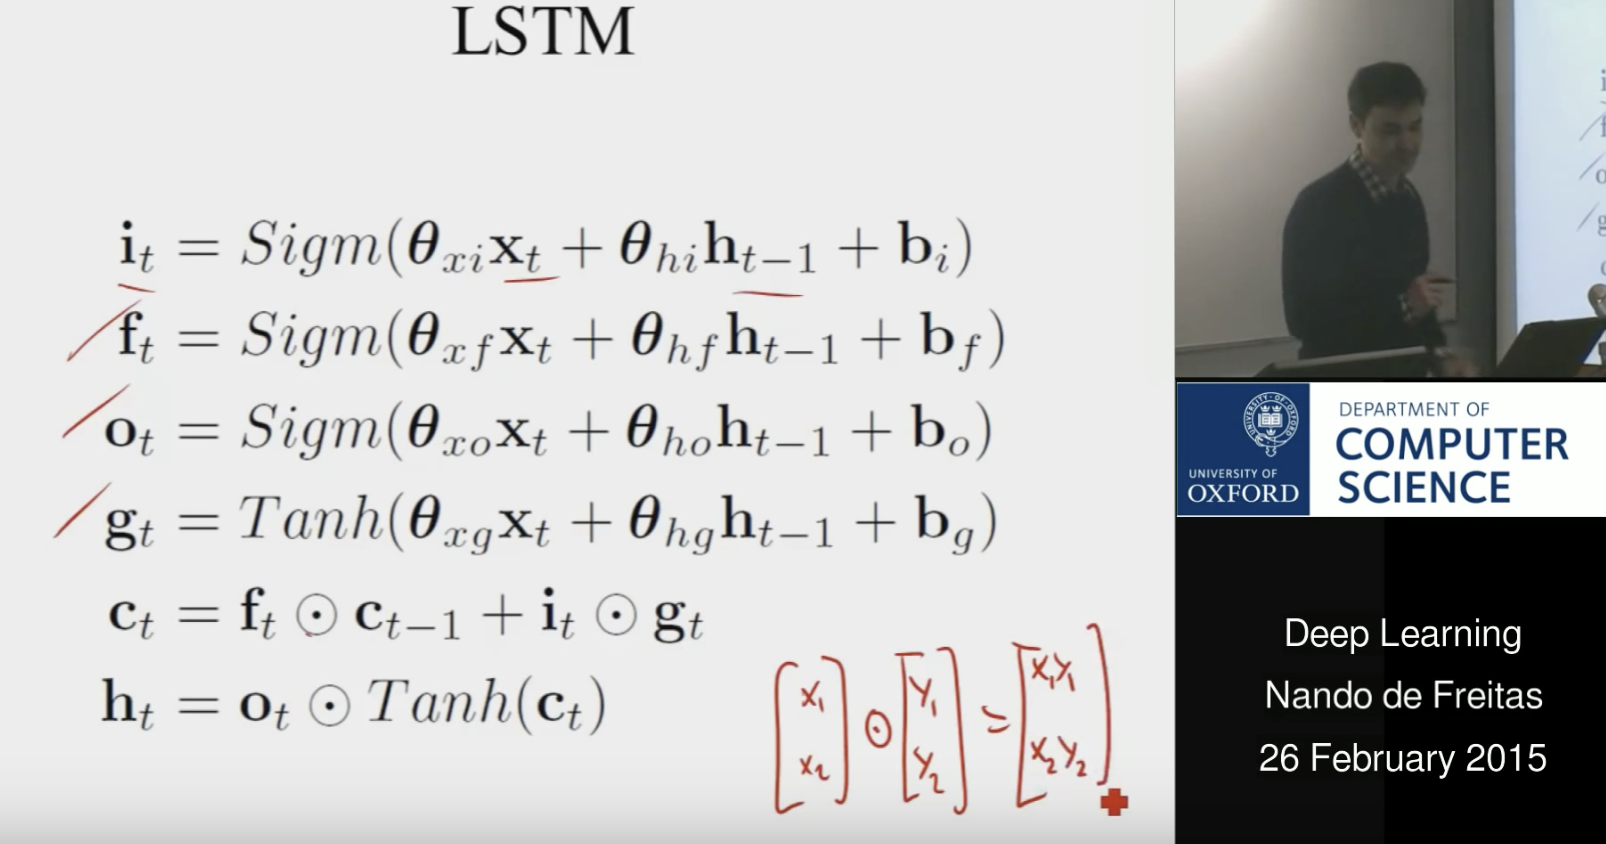

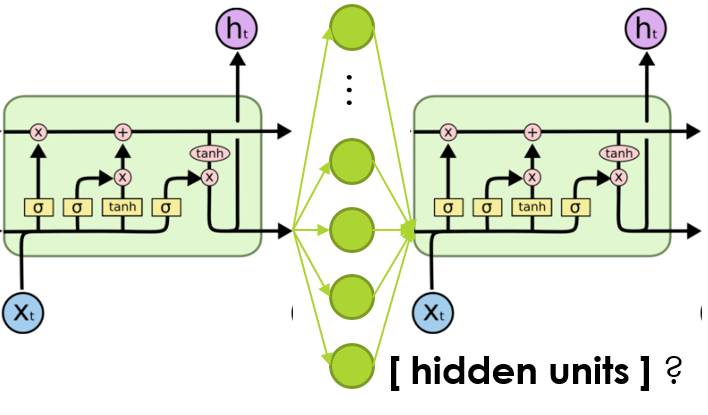
<img src="lstm_structure.JPG">

<font size=5>If you have some questions about **LSTM structure**, check discussion here </font> 
## [Forum](https://discussions.udacity.com/t/confusion-regarding-lstm-code-implementation/229533/3)<br>

In [17]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        # LSTM cell的个数, 有几个cell就代表有几层, 至于横向时间展开是为了方便理解, 实际并不存在
        out_size: Size of this softmax layer
        # softmax layer应该和text中出现的字母种类数保持一致, 返回一个概率list, 每个位置代表相应的概率
    '''

    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output, axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    # reshape中的-1表示推断, 即给出其中一个维度参数的情况下, 推断出另一个维度应该是多少
    # in_size表示LSTM cell的个数, 这一步的输出应该是每层cell的输出列成一列
    x = tf.reshape(seq_output, [-1,in_size]) 
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal([in_size,out_size], stddev=0.1, dtype=tf.float32))
        softmax_b = tf.Variable(tf.zeros(out_size))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.matmul(x, softmax_w) + softmax_b
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits, name='prediction')
    
    return out, logits

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

>**Exercise:** Implement the loss calculation in the function below.

In [18]:
def build_loss(logits, targets, lstm_size, num_classes):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets, num_classes)
    y_reshaped = tf.reshape(y_one_hot, shape=(logits.shape))
    
    # Softmax cross entropy loss
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped)
    loss = tf.reduce_mean(loss)
    
    return loss

# def build_loss(logits, targets, lstm_size, num_classes):
#     ''' Calculate the loss from the logits and the targets.
    
#         Arguments
#         ---------
#         logits: Logits from final fully connected layer
#         targets: Targets for supervised learning
#         lstm_size: Number of LSTM hidden units
#         num_classes: Number of classes in targets
        
#     '''
    
#     # One-hot encode targets and reshape to match logits, one row per batch_size per step
#     y_one_hot = tf.one_hot(targets, num_classes)
#     y_reshaped = tf.reshape(y_one_hot, logits.get_shape())
    
#     # Softmax cross entropy loss
#     loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped)
#     loss = tf.reduce_mean(loss)
#     return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.
<br>
### [tf.trainable_variables](https://www.tensorflow.org/api_docs/python/tf/trainable_variables)
<br>
### [tf.clip_by_global_norm](https://www.tensorflow.org/api_docs/python/tf/clip_by_global_norm)
<br>
### [tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)
<br>
### [tf.gradients](https://www.tensorflow.org/api_docs/python/tf/gradients)
<br>

In [45]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    
    # 只要Variable变量的 trainable = True(默认为True), 则tf.trainable_variables()会收集所有Variable类的实例(变量).
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [tf.nn.dynamic_rnn](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). 
This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 

> **Exercise:** Use the functions you've implemented previously and `tf.nn.dynamic_rnn` to build the network.

### [tf.reset_default_graph](https://www.tensorflow.org/api_docs/python/tf/reset_default_graph)
<br>

In [20]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps
            
        # Reset graph    
        tf.reset_default_graph()
        
        #build input placeholder
        self.inputs, self.targets, self.keep_prob = build_inputs(batch_size, num_steps) 
        
        # Build the LSTM cell
        self.lstm, self.initial_state = build_lstm(lstm_size, num_layers, batch_size, self.keep_prob)
        
        ### Run the data through the RNN layer
        # one-hot encode the input token
        x_one_hot = tf.one_hot(self.inputs, num_classes)
        
        # Run each sequence step through RNN with tf.nn.dynamic_run
        outputs, state = tf.nn.dynamic_rnn(self.lstm, x_one_hot, initial_state=self.initial_state)
        self.final_state = state
        
        # Get softmax prediction and logits
        self.prediction, self.logits = build_output(outputs, lstm_size, num_classes)
        
        # Loss and optimizer (with gradient clipping)
        self.loss =  build_loss(self.logits, self.targets, lstm_size, num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate, grad_clip)

## Hyperparameters

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

Here's some good advice from Andrej Karpathy on training the network. I'm going to copy it in here for your benefit, but also link to [where it originally came from](https://github.com/karpathy/char-rnn#tips-and-tricks).

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `lstm_size` and `num_layers`. I would advise that you always use `num_layers` of either 2 or 3. The `lstm_size` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `lstm_size` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

In [21]:
# batch_size = 100         # Sequences per batch
# num_steps = 50          # Number of sequence steps per batch
# lstm_size = 128         # Size of hidden layers in LSTMs
# num_layers = 2          # Number of LSTM layers
# learning_rate = 0.01    # Learning rate
# keep_prob = 0.5         # Dropout keep probability


batch_size = 100        # Sequences per batch
num_steps = 100         # Number of sequence steps per batch
lstm_size = 512         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.001   # Learning rate
keep_prob = 0.5         # Dropout keep probability

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`

> **Exercise:** Set the hyperparameters above to train the network. Watch the training loss, it should be consistently dropping. Also, I highly advise running this on a GPU.
<br>
### [tf.train.Saver](https://www.tensorflow.org/api_docs/python/tf/train/Saver)
<br>

In [16]:
epochs = 20
# Save every N iterations
save_every_n = 200

model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)

saver = tf.train.Saver(max_to_keep=100)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
#     saver.restore(sess, 'checkpoints/i78200_l128.ckpt')
    counter = 0
    for e in range(epochs):
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(encoded, batch_size, num_steps):
            counter += 1
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
            
            end = time.time()
            print('Epoch: {}/{}... '.format(e+1, epochs),
                  'Training Step: {}... '.format(counter),
                  'Training loss: {:.4f}... '.format(batch_loss),
                  '{:.4f} sec/batch'.format((end-start)))
        
            if (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
    
    saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))

Epoch: 1/20...  Training Step: 1...  Training loss: 4.4164...  2.8076 sec/batch
Epoch: 1/20...  Training Step: 2...  Training loss: 4.3173...  2.7821 sec/batch
Epoch: 1/20...  Training Step: 3...  Training loss: 3.7911...  2.7530 sec/batch
Epoch: 1/20...  Training Step: 4...  Training loss: 4.4541...  2.7316 sec/batch
Epoch: 1/20...  Training Step: 5...  Training loss: 3.8835...  2.7605 sec/batch
Epoch: 1/20...  Training Step: 6...  Training loss: 3.6637...  2.7513 sec/batch
Epoch: 1/20...  Training Step: 7...  Training loss: 3.5058...  2.7242 sec/batch
Epoch: 1/20...  Training Step: 8...  Training loss: 3.4287...  2.7361 sec/batch
Epoch: 1/20...  Training Step: 9...  Training loss: 3.3938...  2.7505 sec/batch
Epoch: 1/20...  Training Step: 10...  Training loss: 3.3630...  2.7339 sec/batch
Epoch: 1/20...  Training Step: 11...  Training loss: 3.3260...  2.7226 sec/batch
Epoch: 1/20...  Training Step: 12...  Training loss: 3.3286...  2.7292 sec/batch
Epoch: 1/20...  Training Step: 13... 

Epoch: 1/20...  Training Step: 103...  Training loss: 3.0417...  2.9017 sec/batch
Epoch: 1/20...  Training Step: 104...  Training loss: 3.0316...  2.8917 sec/batch
Epoch: 1/20...  Training Step: 105...  Training loss: 3.0229...  2.8466 sec/batch
Epoch: 1/20...  Training Step: 106...  Training loss: 3.0247...  2.8070 sec/batch
Epoch: 1/20...  Training Step: 107...  Training loss: 2.9888...  2.8802 sec/batch
Epoch: 1/20...  Training Step: 108...  Training loss: 3.0025...  2.8160 sec/batch
Epoch: 1/20...  Training Step: 109...  Training loss: 3.0029...  2.8385 sec/batch
Epoch: 1/20...  Training Step: 110...  Training loss: 2.9553...  2.8732 sec/batch
Epoch: 1/20...  Training Step: 111...  Training loss: 2.9833...  2.8957 sec/batch
Epoch: 1/20...  Training Step: 112...  Training loss: 2.9977...  2.7744 sec/batch
Epoch: 1/20...  Training Step: 113...  Training loss: 2.9860...  2.7696 sec/batch
Epoch: 1/20...  Training Step: 114...  Training loss: 2.9776...  2.8900 sec/batch
Epoch: 1/20...  

Epoch: 2/20...  Training Step: 203...  Training loss: 2.4389...  2.9379 sec/batch
Epoch: 2/20...  Training Step: 204...  Training loss: 2.4392...  2.8338 sec/batch
Epoch: 2/20...  Training Step: 205...  Training loss: 2.4372...  2.9020 sec/batch
Epoch: 2/20...  Training Step: 206...  Training loss: 2.4413...  2.8218 sec/batch
Epoch: 2/20...  Training Step: 207...  Training loss: 2.4615...  2.8594 sec/batch
Epoch: 2/20...  Training Step: 208...  Training loss: 2.4286...  2.7621 sec/batch
Epoch: 2/20...  Training Step: 209...  Training loss: 2.4204...  2.6858 sec/batch
Epoch: 2/20...  Training Step: 210...  Training loss: 2.4260...  2.7480 sec/batch
Epoch: 2/20...  Training Step: 211...  Training loss: 2.4255...  2.7927 sec/batch
Epoch: 2/20...  Training Step: 212...  Training loss: 2.4485...  2.7115 sec/batch
Epoch: 2/20...  Training Step: 213...  Training loss: 2.4222...  2.7626 sec/batch
Epoch: 2/20...  Training Step: 214...  Training loss: 2.4253...  2.8373 sec/batch
Epoch: 2/20...  

Epoch: 2/20...  Training Step: 303...  Training loss: 2.1930...  2.8701 sec/batch
Epoch: 2/20...  Training Step: 304...  Training loss: 2.2149...  2.7212 sec/batch
Epoch: 2/20...  Training Step: 305...  Training loss: 2.2041...  2.7409 sec/batch
Epoch: 2/20...  Training Step: 306...  Training loss: 2.2250...  2.8677 sec/batch
Epoch: 2/20...  Training Step: 307...  Training loss: 2.2135...  2.7260 sec/batch
Epoch: 2/20...  Training Step: 308...  Training loss: 2.1926...  2.6990 sec/batch
Epoch: 2/20...  Training Step: 309...  Training loss: 2.2021...  2.8320 sec/batch
Epoch: 2/20...  Training Step: 310...  Training loss: 2.2061...  2.8679 sec/batch
Epoch: 2/20...  Training Step: 311...  Training loss: 2.1962...  2.7787 sec/batch
Epoch: 2/20...  Training Step: 312...  Training loss: 2.1845...  2.7305 sec/batch
Epoch: 2/20...  Training Step: 313...  Training loss: 2.1667...  2.7756 sec/batch
Epoch: 2/20...  Training Step: 314...  Training loss: 2.1599...  2.8411 sec/batch
Epoch: 2/20...  

Epoch: 3/20...  Training Step: 403...  Training loss: 2.0567...  2.8782 sec/batch
Epoch: 3/20...  Training Step: 404...  Training loss: 2.0614...  2.7465 sec/batch
Epoch: 3/20...  Training Step: 405...  Training loss: 2.0793...  2.7955 sec/batch
Epoch: 3/20...  Training Step: 406...  Training loss: 2.0547...  2.8475 sec/batch
Epoch: 3/20...  Training Step: 407...  Training loss: 2.0358...  2.7172 sec/batch
Epoch: 3/20...  Training Step: 408...  Training loss: 2.0325...  2.6886 sec/batch
Epoch: 3/20...  Training Step: 409...  Training loss: 2.0549...  2.7280 sec/batch
Epoch: 3/20...  Training Step: 410...  Training loss: 2.0817...  2.8079 sec/batch
Epoch: 3/20...  Training Step: 411...  Training loss: 2.0436...  2.7269 sec/batch
Epoch: 3/20...  Training Step: 412...  Training loss: 2.0320...  2.7769 sec/batch
Epoch: 3/20...  Training Step: 413...  Training loss: 2.0329...  2.7969 sec/batch
Epoch: 3/20...  Training Step: 414...  Training loss: 2.0844...  2.7767 sec/batch
Epoch: 3/20...  

Epoch: 3/20...  Training Step: 503...  Training loss: 1.9265...  2.7673 sec/batch
Epoch: 3/20...  Training Step: 504...  Training loss: 1.9533...  2.7588 sec/batch
Epoch: 3/20...  Training Step: 505...  Training loss: 1.9463...  2.8126 sec/batch
Epoch: 3/20...  Training Step: 506...  Training loss: 1.9357...  2.8632 sec/batch
Epoch: 3/20...  Training Step: 507...  Training loss: 1.9284...  2.8106 sec/batch
Epoch: 3/20...  Training Step: 508...  Training loss: 1.9118...  2.8700 sec/batch
Epoch: 3/20...  Training Step: 509...  Training loss: 1.9218...  2.8704 sec/batch
Epoch: 3/20...  Training Step: 510...  Training loss: 1.9096...  2.7260 sec/batch
Epoch: 3/20...  Training Step: 511...  Training loss: 1.9044...  2.7460 sec/batch
Epoch: 3/20...  Training Step: 512...  Training loss: 1.8839...  2.7818 sec/batch
Epoch: 3/20...  Training Step: 513...  Training loss: 1.9144...  2.8533 sec/batch
Epoch: 3/20...  Training Step: 514...  Training loss: 1.9076...  2.6819 sec/batch
Epoch: 3/20...  

Epoch: 4/20...  Training Step: 603...  Training loss: 1.8732...  2.7979 sec/batch
Epoch: 4/20...  Training Step: 604...  Training loss: 1.8387...  2.8211 sec/batch
Epoch: 4/20...  Training Step: 605...  Training loss: 1.8119...  2.8695 sec/batch
Epoch: 4/20...  Training Step: 606...  Training loss: 1.8234...  2.7320 sec/batch
Epoch: 4/20...  Training Step: 607...  Training loss: 1.8396...  2.7574 sec/batch
Epoch: 4/20...  Training Step: 608...  Training loss: 1.8868...  2.7696 sec/batch
Epoch: 4/20...  Training Step: 609...  Training loss: 1.8317...  2.8545 sec/batch
Epoch: 4/20...  Training Step: 610...  Training loss: 1.8177...  2.7711 sec/batch
Epoch: 4/20...  Training Step: 611...  Training loss: 1.8344...  2.7781 sec/batch
Epoch: 4/20...  Training Step: 612...  Training loss: 1.8726...  2.7309 sec/batch
Epoch: 4/20...  Training Step: 613...  Training loss: 1.8370...  2.7706 sec/batch
Epoch: 4/20...  Training Step: 614...  Training loss: 1.8446...  2.6855 sec/batch
Epoch: 4/20...  

Epoch: 4/20...  Training Step: 703...  Training loss: 1.7805...  2.6719 sec/batch
Epoch: 4/20...  Training Step: 704...  Training loss: 1.7823...  2.7370 sec/batch
Epoch: 4/20...  Training Step: 705...  Training loss: 1.7678...  2.8163 sec/batch
Epoch: 4/20...  Training Step: 706...  Training loss: 1.7479...  2.7140 sec/batch
Epoch: 4/20...  Training Step: 707...  Training loss: 1.7533...  2.9028 sec/batch
Epoch: 4/20...  Training Step: 708...  Training loss: 1.7519...  2.9400 sec/batch
Epoch: 4/20...  Training Step: 709...  Training loss: 1.7361...  2.8908 sec/batch
Epoch: 4/20...  Training Step: 710...  Training loss: 1.7182...  2.7174 sec/batch
Epoch: 4/20...  Training Step: 711...  Training loss: 1.7631...  2.7599 sec/batch
Epoch: 4/20...  Training Step: 712...  Training loss: 1.7446...  3.0903 sec/batch
Epoch: 4/20...  Training Step: 713...  Training loss: 1.7516...  2.9421 sec/batch
Epoch: 4/20...  Training Step: 714...  Training loss: 1.7542...  2.7484 sec/batch
Epoch: 4/20...  

Epoch: 5/20...  Training Step: 803...  Training loss: 1.6747...  2.7689 sec/batch
Epoch: 5/20...  Training Step: 804...  Training loss: 1.6811...  2.8270 sec/batch
Epoch: 5/20...  Training Step: 805...  Training loss: 1.7011...  2.9123 sec/batch
Epoch: 5/20...  Training Step: 806...  Training loss: 1.7336...  2.8686 sec/batch
Epoch: 5/20...  Training Step: 807...  Training loss: 1.6982...  2.8621 sec/batch
Epoch: 5/20...  Training Step: 808...  Training loss: 1.6881...  2.9173 sec/batch
Epoch: 5/20...  Training Step: 809...  Training loss: 1.7059...  2.9654 sec/batch
Epoch: 5/20...  Training Step: 810...  Training loss: 1.7265...  2.7699 sec/batch
Epoch: 5/20...  Training Step: 811...  Training loss: 1.6999...  2.8656 sec/batch
Epoch: 5/20...  Training Step: 812...  Training loss: 1.7131...  2.9589 sec/batch
Epoch: 5/20...  Training Step: 813...  Training loss: 1.6945...  2.8014 sec/batch
Epoch: 5/20...  Training Step: 814...  Training loss: 1.7361...  2.7899 sec/batch
Epoch: 5/20...  

Epoch: 5/20...  Training Step: 903...  Training loss: 1.6455...  2.6720 sec/batch
Epoch: 5/20...  Training Step: 904...  Training loss: 1.6369...  2.7057 sec/batch
Epoch: 5/20...  Training Step: 905...  Training loss: 1.6409...  2.7196 sec/batch
Epoch: 5/20...  Training Step: 906...  Training loss: 1.6284...  2.6984 sec/batch
Epoch: 5/20...  Training Step: 907...  Training loss: 1.6313...  2.7080 sec/batch
Epoch: 5/20...  Training Step: 908...  Training loss: 1.6100...  2.8117 sec/batch
Epoch: 5/20...  Training Step: 909...  Training loss: 1.6571...  2.7077 sec/batch
Epoch: 5/20...  Training Step: 910...  Training loss: 1.6482...  2.6599 sec/batch
Epoch: 5/20...  Training Step: 911...  Training loss: 1.6405...  2.7300 sec/batch
Epoch: 5/20...  Training Step: 912...  Training loss: 1.6425...  2.8477 sec/batch
Epoch: 5/20...  Training Step: 913...  Training loss: 1.6499...  2.6845 sec/batch
Epoch: 5/20...  Training Step: 914...  Training loss: 1.6117...  2.7116 sec/batch
Epoch: 5/20...  

Epoch: 6/20...  Training Step: 1003...  Training loss: 1.5904...  2.6612 sec/batch
Epoch: 6/20...  Training Step: 1004...  Training loss: 1.6325...  2.7557 sec/batch
Epoch: 6/20...  Training Step: 1005...  Training loss: 1.5919...  2.6759 sec/batch
Epoch: 6/20...  Training Step: 1006...  Training loss: 1.5751...  2.6649 sec/batch
Epoch: 6/20...  Training Step: 1007...  Training loss: 1.6042...  2.7117 sec/batch
Epoch: 6/20...  Training Step: 1008...  Training loss: 1.6199...  2.7449 sec/batch
Epoch: 6/20...  Training Step: 1009...  Training loss: 1.6072...  2.6428 sec/batch
Epoch: 6/20...  Training Step: 1010...  Training loss: 1.6193...  2.6625 sec/batch
Epoch: 6/20...  Training Step: 1011...  Training loss: 1.5843...  2.7229 sec/batch
Epoch: 6/20...  Training Step: 1012...  Training loss: 1.6246...  2.7175 sec/batch
Epoch: 6/20...  Training Step: 1013...  Training loss: 1.5873...  2.6699 sec/batch
Epoch: 6/20...  Training Step: 1014...  Training loss: 1.5977...  2.6464 sec/batch
Epoc

Epoch: 6/20...  Training Step: 1102...  Training loss: 1.5556...  2.7015 sec/batch
Epoch: 6/20...  Training Step: 1103...  Training loss: 1.5448...  2.7271 sec/batch
Epoch: 6/20...  Training Step: 1104...  Training loss: 1.5358...  2.7572 sec/batch
Epoch: 6/20...  Training Step: 1105...  Training loss: 1.5321...  2.6855 sec/batch
Epoch: 6/20...  Training Step: 1106...  Training loss: 1.5110...  2.6848 sec/batch
Epoch: 6/20...  Training Step: 1107...  Training loss: 1.5501...  2.6671 sec/batch
Epoch: 6/20...  Training Step: 1108...  Training loss: 1.5596...  2.7961 sec/batch
Epoch: 6/20...  Training Step: 1109...  Training loss: 1.5520...  2.7127 sec/batch
Epoch: 6/20...  Training Step: 1110...  Training loss: 1.5430...  2.7541 sec/batch
Epoch: 6/20...  Training Step: 1111...  Training loss: 1.5494...  2.8287 sec/batch
Epoch: 6/20...  Training Step: 1112...  Training loss: 1.5151...  2.8849 sec/batch
Epoch: 6/20...  Training Step: 1113...  Training loss: 1.4990...  2.7041 sec/batch
Epoc

Epoch: 7/20...  Training Step: 1201...  Training loss: 1.5121...  2.7107 sec/batch
Epoch: 7/20...  Training Step: 1202...  Training loss: 1.5544...  2.6569 sec/batch
Epoch: 7/20...  Training Step: 1203...  Training loss: 1.5118...  2.7576 sec/batch
Epoch: 7/20...  Training Step: 1204...  Training loss: 1.4931...  2.8019 sec/batch
Epoch: 7/20...  Training Step: 1205...  Training loss: 1.5308...  2.6919 sec/batch
Epoch: 7/20...  Training Step: 1206...  Training loss: 1.5419...  2.6409 sec/batch
Epoch: 7/20...  Training Step: 1207...  Training loss: 1.5283...  2.7026 sec/batch
Epoch: 7/20...  Training Step: 1208...  Training loss: 1.5427...  2.8262 sec/batch
Epoch: 7/20...  Training Step: 1209...  Training loss: 1.5145...  2.6951 sec/batch
Epoch: 7/20...  Training Step: 1210...  Training loss: 1.5348...  2.7566 sec/batch
Epoch: 7/20...  Training Step: 1211...  Training loss: 1.5101...  2.7462 sec/batch
Epoch: 7/20...  Training Step: 1212...  Training loss: 1.5115...  2.6603 sec/batch
Epoc

Epoch: 7/20...  Training Step: 1300...  Training loss: 1.4854...  2.6893 sec/batch
Epoch: 7/20...  Training Step: 1301...  Training loss: 1.4813...  2.6595 sec/batch
Epoch: 7/20...  Training Step: 1302...  Training loss: 1.4746...  2.6739 sec/batch
Epoch: 7/20...  Training Step: 1303...  Training loss: 1.4526...  2.7229 sec/batch
Epoch: 7/20...  Training Step: 1304...  Training loss: 1.4482...  2.6516 sec/batch
Epoch: 7/20...  Training Step: 1305...  Training loss: 1.4818...  2.6716 sec/batch
Epoch: 7/20...  Training Step: 1306...  Training loss: 1.4897...  2.7215 sec/batch
Epoch: 7/20...  Training Step: 1307...  Training loss: 1.4706...  2.7565 sec/batch
Epoch: 7/20...  Training Step: 1308...  Training loss: 1.4726...  2.6688 sec/batch
Epoch: 7/20...  Training Step: 1309...  Training loss: 1.4848...  2.6869 sec/batch
Epoch: 7/20...  Training Step: 1310...  Training loss: 1.4421...  2.7175 sec/batch
Epoch: 7/20...  Training Step: 1311...  Training loss: 1.4389...  2.7598 sec/batch
Epoc

Epoch: 8/20...  Training Step: 1399...  Training loss: 1.4657...  2.7703 sec/batch
Epoch: 8/20...  Training Step: 1400...  Training loss: 1.4941...  2.6242 sec/batch
Epoch: 8/20...  Training Step: 1401...  Training loss: 1.4677...  2.6762 sec/batch
Epoch: 8/20...  Training Step: 1402...  Training loss: 1.4494...  2.7159 sec/batch
Epoch: 8/20...  Training Step: 1403...  Training loss: 1.4814...  2.7709 sec/batch
Epoch: 8/20...  Training Step: 1404...  Training loss: 1.4823...  2.7055 sec/batch
Epoch: 8/20...  Training Step: 1405...  Training loss: 1.4790...  2.7474 sec/batch
Epoch: 8/20...  Training Step: 1406...  Training loss: 1.4905...  2.7278 sec/batch
Epoch: 8/20...  Training Step: 1407...  Training loss: 1.4589...  2.8026 sec/batch
Epoch: 8/20...  Training Step: 1408...  Training loss: 1.5016...  2.7145 sec/batch
Epoch: 8/20...  Training Step: 1409...  Training loss: 1.4521...  2.6855 sec/batch
Epoch: 8/20...  Training Step: 1410...  Training loss: 1.4720...  2.7917 sec/batch
Epoc

Epoch: 8/20...  Training Step: 1498...  Training loss: 1.4444...  2.7377 sec/batch
Epoch: 8/20...  Training Step: 1499...  Training loss: 1.4335...  2.8361 sec/batch
Epoch: 8/20...  Training Step: 1500...  Training loss: 1.4271...  2.7189 sec/batch
Epoch: 8/20...  Training Step: 1501...  Training loss: 1.4122...  2.6885 sec/batch
Epoch: 8/20...  Training Step: 1502...  Training loss: 1.3958...  2.7604 sec/batch
Epoch: 8/20...  Training Step: 1503...  Training loss: 1.4298...  2.8696 sec/batch
Epoch: 8/20...  Training Step: 1504...  Training loss: 1.4364...  2.7523 sec/batch
Epoch: 8/20...  Training Step: 1505...  Training loss: 1.4294...  3.0611 sec/batch
Epoch: 8/20...  Training Step: 1506...  Training loss: 1.4330...  3.0699 sec/batch
Epoch: 8/20...  Training Step: 1507...  Training loss: 1.4392...  2.9828 sec/batch
Epoch: 8/20...  Training Step: 1508...  Training loss: 1.4008...  2.8359 sec/batch
Epoch: 8/20...  Training Step: 1509...  Training loss: 1.3875...  2.8606 sec/batch
Epoc

Epoch: 9/20...  Training Step: 1597...  Training loss: 1.4154...  2.6646 sec/batch
Epoch: 9/20...  Training Step: 1598...  Training loss: 1.4297...  2.6852 sec/batch
Epoch: 9/20...  Training Step: 1599...  Training loss: 1.4128...  2.7973 sec/batch
Epoch: 9/20...  Training Step: 1600...  Training loss: 1.3925...  2.7297 sec/batch
Epoch: 9/20...  Training Step: 1601...  Training loss: 1.4274...  2.6923 sec/batch
Epoch: 9/20...  Training Step: 1602...  Training loss: 1.4469...  2.6816 sec/batch
Epoch: 9/20...  Training Step: 1603...  Training loss: 1.4147...  2.7407 sec/batch
Epoch: 9/20...  Training Step: 1604...  Training loss: 1.4429...  2.6661 sec/batch
Epoch: 9/20...  Training Step: 1605...  Training loss: 1.4163...  2.7606 sec/batch
Epoch: 9/20...  Training Step: 1606...  Training loss: 1.4358...  2.7841 sec/batch
Epoch: 9/20...  Training Step: 1607...  Training loss: 1.4019...  2.7614 sec/batch
Epoch: 9/20...  Training Step: 1608...  Training loss: 1.4216...  2.6725 sec/batch
Epoc

Epoch: 9/20...  Training Step: 1696...  Training loss: 1.3974...  2.7136 sec/batch
Epoch: 9/20...  Training Step: 1697...  Training loss: 1.4026...  2.7459 sec/batch
Epoch: 9/20...  Training Step: 1698...  Training loss: 1.3800...  2.7598 sec/batch
Epoch: 9/20...  Training Step: 1699...  Training loss: 1.3815...  2.6786 sec/batch
Epoch: 9/20...  Training Step: 1700...  Training loss: 1.3575...  2.6997 sec/batch
Epoch: 9/20...  Training Step: 1701...  Training loss: 1.4016...  2.7351 sec/batch
Epoch: 9/20...  Training Step: 1702...  Training loss: 1.3982...  2.7383 sec/batch
Epoch: 9/20...  Training Step: 1703...  Training loss: 1.3897...  2.7175 sec/batch
Epoch: 9/20...  Training Step: 1704...  Training loss: 1.3926...  2.6631 sec/batch
Epoch: 9/20...  Training Step: 1705...  Training loss: 1.3919...  2.7286 sec/batch
Epoch: 9/20...  Training Step: 1706...  Training loss: 1.3592...  2.8330 sec/batch
Epoch: 9/20...  Training Step: 1707...  Training loss: 1.3432...  2.6876 sec/batch
Epoc

Epoch: 10/20...  Training Step: 1795...  Training loss: 1.3841...  2.6525 sec/batch
Epoch: 10/20...  Training Step: 1796...  Training loss: 1.4096...  2.6409 sec/batch
Epoch: 10/20...  Training Step: 1797...  Training loss: 1.3743...  2.7231 sec/batch
Epoch: 10/20...  Training Step: 1798...  Training loss: 1.3605...  2.7890 sec/batch
Epoch: 10/20...  Training Step: 1799...  Training loss: 1.4020...  2.6851 sec/batch
Epoch: 10/20...  Training Step: 1800...  Training loss: 1.4079...  2.6356 sec/batch
Epoch: 10/20...  Training Step: 1801...  Training loss: 1.4046...  2.7645 sec/batch
Epoch: 10/20...  Training Step: 1802...  Training loss: 1.4152...  2.7039 sec/batch
Epoch: 10/20...  Training Step: 1803...  Training loss: 1.3905...  2.6573 sec/batch
Epoch: 10/20...  Training Step: 1804...  Training loss: 1.4046...  2.6606 sec/batch
Epoch: 10/20...  Training Step: 1805...  Training loss: 1.3817...  2.6875 sec/batch
Epoch: 10/20...  Training Step: 1806...  Training loss: 1.3944...  2.7809 se

Epoch: 10/20...  Training Step: 1893...  Training loss: 1.3520...  2.6861 sec/batch
Epoch: 10/20...  Training Step: 1894...  Training loss: 1.3771...  2.7692 sec/batch
Epoch: 10/20...  Training Step: 1895...  Training loss: 1.3678...  2.7145 sec/batch
Epoch: 10/20...  Training Step: 1896...  Training loss: 1.3558...  2.6629 sec/batch
Epoch: 10/20...  Training Step: 1897...  Training loss: 1.3423...  2.7093 sec/batch
Epoch: 10/20...  Training Step: 1898...  Training loss: 1.3245...  2.8090 sec/batch
Epoch: 10/20...  Training Step: 1899...  Training loss: 1.3794...  2.6602 sec/batch
Epoch: 10/20...  Training Step: 1900...  Training loss: 1.3713...  2.7852 sec/batch
Epoch: 10/20...  Training Step: 1901...  Training loss: 1.3625...  2.7590 sec/batch
Epoch: 10/20...  Training Step: 1902...  Training loss: 1.3651...  2.7071 sec/batch
Epoch: 10/20...  Training Step: 1903...  Training loss: 1.3644...  2.6662 sec/batch
Epoch: 10/20...  Training Step: 1904...  Training loss: 1.3339...  2.6879 se

Epoch: 11/20...  Training Step: 1991...  Training loss: 1.3324...  2.6528 sec/batch
Epoch: 11/20...  Training Step: 1992...  Training loss: 1.3520...  2.6605 sec/batch
Epoch: 11/20...  Training Step: 1993...  Training loss: 1.3617...  2.7031 sec/batch
Epoch: 11/20...  Training Step: 1994...  Training loss: 1.3785...  2.8526 sec/batch
Epoch: 11/20...  Training Step: 1995...  Training loss: 1.3379...  2.6922 sec/batch
Epoch: 11/20...  Training Step: 1996...  Training loss: 1.3337...  2.6910 sec/batch
Epoch: 11/20...  Training Step: 1997...  Training loss: 1.3712...  2.7107 sec/batch
Epoch: 11/20...  Training Step: 1998...  Training loss: 1.3870...  2.7536 sec/batch
Epoch: 11/20...  Training Step: 1999...  Training loss: 1.3688...  2.6597 sec/batch
Epoch: 11/20...  Training Step: 2000...  Training loss: 1.3838...  2.7292 sec/batch
Epoch: 11/20...  Training Step: 2001...  Training loss: 1.3625...  2.7041 sec/batch
Epoch: 11/20...  Training Step: 2002...  Training loss: 1.3748...  2.6340 se

Epoch: 11/20...  Training Step: 2089...  Training loss: 1.3324...  2.7073 sec/batch
Epoch: 11/20...  Training Step: 2090...  Training loss: 1.3610...  2.7705 sec/batch
Epoch: 11/20...  Training Step: 2091...  Training loss: 1.3337...  2.6736 sec/batch
Epoch: 11/20...  Training Step: 2092...  Training loss: 1.3441...  2.6518 sec/batch
Epoch: 11/20...  Training Step: 2093...  Training loss: 1.3434...  2.6293 sec/batch
Epoch: 11/20...  Training Step: 2094...  Training loss: 1.3326...  2.8244 sec/batch
Epoch: 11/20...  Training Step: 2095...  Training loss: 1.3219...  2.6857 sec/batch
Epoch: 11/20...  Training Step: 2096...  Training loss: 1.3064...  2.6924 sec/batch
Epoch: 11/20...  Training Step: 2097...  Training loss: 1.3473...  2.6851 sec/batch
Epoch: 11/20...  Training Step: 2098...  Training loss: 1.3463...  2.6288 sec/batch
Epoch: 11/20...  Training Step: 2099...  Training loss: 1.3301...  2.6483 sec/batch
Epoch: 11/20...  Training Step: 2100...  Training loss: 1.3304...  2.7056 se

Epoch: 12/20...  Training Step: 2187...  Training loss: 1.3413...  2.6973 sec/batch
Epoch: 12/20...  Training Step: 2188...  Training loss: 1.3284...  2.6913 sec/batch
Epoch: 12/20...  Training Step: 2189...  Training loss: 1.3092...  2.7148 sec/batch
Epoch: 12/20...  Training Step: 2190...  Training loss: 1.3152...  2.6462 sec/batch
Epoch: 12/20...  Training Step: 2191...  Training loss: 1.3305...  2.6660 sec/batch
Epoch: 12/20...  Training Step: 2192...  Training loss: 1.3479...  2.6953 sec/batch
Epoch: 12/20...  Training Step: 2193...  Training loss: 1.3230...  2.7591 sec/batch
Epoch: 12/20...  Training Step: 2194...  Training loss: 1.3127...  2.7070 sec/batch
Epoch: 12/20...  Training Step: 2195...  Training loss: 1.3476...  2.6763 sec/batch
Epoch: 12/20...  Training Step: 2196...  Training loss: 1.3587...  2.7074 sec/batch
Epoch: 12/20...  Training Step: 2197...  Training loss: 1.3419...  2.7486 sec/batch
Epoch: 12/20...  Training Step: 2198...  Training loss: 1.3569...  2.6712 se

Epoch: 12/20...  Training Step: 2285...  Training loss: 1.3263...  2.8385 sec/batch
Epoch: 12/20...  Training Step: 2286...  Training loss: 1.3307...  2.7498 sec/batch
Epoch: 12/20...  Training Step: 2287...  Training loss: 1.3086...  2.6793 sec/batch
Epoch: 12/20...  Training Step: 2288...  Training loss: 1.3379...  2.7534 sec/batch
Epoch: 12/20...  Training Step: 2289...  Training loss: 1.3045...  2.8576 sec/batch
Epoch: 12/20...  Training Step: 2290...  Training loss: 1.3354...  2.7338 sec/batch
Epoch: 12/20...  Training Step: 2291...  Training loss: 1.3240...  2.6749 sec/batch
Epoch: 12/20...  Training Step: 2292...  Training loss: 1.3095...  2.7389 sec/batch
Epoch: 12/20...  Training Step: 2293...  Training loss: 1.2954...  2.7806 sec/batch
Epoch: 12/20...  Training Step: 2294...  Training loss: 1.2867...  2.6382 sec/batch
Epoch: 12/20...  Training Step: 2295...  Training loss: 1.3235...  2.6639 sec/batch
Epoch: 12/20...  Training Step: 2296...  Training loss: 1.3358...  2.6557 se

Epoch: 13/20...  Training Step: 2383...  Training loss: 1.3090...  2.6539 sec/batch
Epoch: 13/20...  Training Step: 2384...  Training loss: 1.3027...  2.6763 sec/batch
Epoch: 13/20...  Training Step: 2385...  Training loss: 1.3242...  2.8218 sec/batch
Epoch: 13/20...  Training Step: 2386...  Training loss: 1.3043...  2.7255 sec/batch
Epoch: 13/20...  Training Step: 2387...  Training loss: 1.2973...  2.6527 sec/batch
Epoch: 13/20...  Training Step: 2388...  Training loss: 1.3037...  2.7206 sec/batch
Epoch: 13/20...  Training Step: 2389...  Training loss: 1.3124...  2.7646 sec/batch
Epoch: 13/20...  Training Step: 2390...  Training loss: 1.3267...  2.6528 sec/batch
Epoch: 13/20...  Training Step: 2391...  Training loss: 1.3018...  2.6957 sec/batch
Epoch: 13/20...  Training Step: 2392...  Training loss: 1.2822...  2.7303 sec/batch
Epoch: 13/20...  Training Step: 2393...  Training loss: 1.3212...  2.6443 sec/batch
Epoch: 13/20...  Training Step: 2394...  Training loss: 1.3349...  2.6621 se

Epoch: 13/20...  Training Step: 2481...  Training loss: 1.2910...  2.7961 sec/batch
Epoch: 13/20...  Training Step: 2482...  Training loss: 1.2932...  2.6851 sec/batch
Epoch: 13/20...  Training Step: 2483...  Training loss: 1.3039...  2.6509 sec/batch
Epoch: 13/20...  Training Step: 2484...  Training loss: 1.3053...  2.6928 sec/batch
Epoch: 13/20...  Training Step: 2485...  Training loss: 1.2881...  2.7757 sec/batch
Epoch: 13/20...  Training Step: 2486...  Training loss: 1.3111...  2.6917 sec/batch
Epoch: 13/20...  Training Step: 2487...  Training loss: 1.2875...  2.6934 sec/batch
Epoch: 13/20...  Training Step: 2488...  Training loss: 1.3026...  2.7740 sec/batch
Epoch: 13/20...  Training Step: 2489...  Training loss: 1.3037...  2.6537 sec/batch
Epoch: 13/20...  Training Step: 2490...  Training loss: 1.2939...  2.6692 sec/batch
Epoch: 13/20...  Training Step: 2491...  Training loss: 1.2659...  2.7088 sec/batch
Epoch: 13/20...  Training Step: 2492...  Training loss: 1.2650...  2.7707 se

Epoch: 14/20...  Training Step: 2579...  Training loss: 1.2632...  2.6826 sec/batch
Epoch: 14/20...  Training Step: 2580...  Training loss: 1.2625...  2.7216 sec/batch
Epoch: 14/20...  Training Step: 2581...  Training loss: 1.3071...  2.7678 sec/batch
Epoch: 14/20...  Training Step: 2582...  Training loss: 1.2925...  2.6782 sec/batch
Epoch: 14/20...  Training Step: 2583...  Training loss: 1.2972...  2.6824 sec/batch
Epoch: 14/20...  Training Step: 2584...  Training loss: 1.2890...  2.7890 sec/batch
Epoch: 14/20...  Training Step: 2585...  Training loss: 1.2804...  2.6829 sec/batch
Epoch: 14/20...  Training Step: 2586...  Training loss: 1.2916...  2.6729 sec/batch
Epoch: 14/20...  Training Step: 2587...  Training loss: 1.2912...  2.7303 sec/batch
Epoch: 14/20...  Training Step: 2588...  Training loss: 1.3114...  2.6853 sec/batch
Epoch: 14/20...  Training Step: 2589...  Training loss: 1.2753...  2.6298 sec/batch
Epoch: 14/20...  Training Step: 2590...  Training loss: 1.2663...  2.6656 se

Epoch: 14/20...  Training Step: 2677...  Training loss: 1.2855...  2.8203 sec/batch
Epoch: 14/20...  Training Step: 2678...  Training loss: 1.2715...  2.6819 sec/batch
Epoch: 14/20...  Training Step: 2679...  Training loss: 1.2777...  2.6797 sec/batch
Epoch: 14/20...  Training Step: 2680...  Training loss: 1.2672...  2.7832 sec/batch
Epoch: 14/20...  Training Step: 2681...  Training loss: 1.2862...  2.6554 sec/batch
Epoch: 14/20...  Training Step: 2682...  Training loss: 1.2882...  2.6787 sec/batch
Epoch: 14/20...  Training Step: 2683...  Training loss: 1.2693...  2.6847 sec/batch
Epoch: 14/20...  Training Step: 2684...  Training loss: 1.2978...  2.7245 sec/batch
Epoch: 14/20...  Training Step: 2685...  Training loss: 1.2779...  2.6588 sec/batch
Epoch: 14/20...  Training Step: 2686...  Training loss: 1.2848...  2.6476 sec/batch
Epoch: 14/20...  Training Step: 2687...  Training loss: 1.2971...  2.6853 sec/batch
Epoch: 14/20...  Training Step: 2688...  Training loss: 1.2809...  2.7669 se

Epoch: 15/20...  Training Step: 2775...  Training loss: 1.2769...  2.7566 sec/batch
Epoch: 15/20...  Training Step: 2776...  Training loss: 1.2966...  2.8429 sec/batch
Epoch: 15/20...  Training Step: 2777...  Training loss: 1.2523...  2.7285 sec/batch
Epoch: 15/20...  Training Step: 2778...  Training loss: 1.2378...  2.6997 sec/batch
Epoch: 15/20...  Training Step: 2779...  Training loss: 1.2861...  2.7038 sec/batch
Epoch: 15/20...  Training Step: 2780...  Training loss: 1.2690...  2.7873 sec/batch
Epoch: 15/20...  Training Step: 2781...  Training loss: 1.2786...  2.6599 sec/batch
Epoch: 15/20...  Training Step: 2782...  Training loss: 1.2637...  2.6452 sec/batch
Epoch: 15/20...  Training Step: 2783...  Training loss: 1.2628...  2.7934 sec/batch
Epoch: 15/20...  Training Step: 2784...  Training loss: 1.2578...  2.8131 sec/batch
Epoch: 15/20...  Training Step: 2785...  Training loss: 1.2776...  2.6524 sec/batch
Epoch: 15/20...  Training Step: 2786...  Training loss: 1.2939...  2.6899 se

Epoch: 15/20...  Training Step: 2873...  Training loss: 1.2705...  2.6923 sec/batch
Epoch: 15/20...  Training Step: 2874...  Training loss: 1.2606...  2.6633 sec/batch
Epoch: 15/20...  Training Step: 2875...  Training loss: 1.2747...  2.7123 sec/batch
Epoch: 15/20...  Training Step: 2876...  Training loss: 1.2580...  2.8004 sec/batch
Epoch: 15/20...  Training Step: 2877...  Training loss: 1.2606...  2.6874 sec/batch
Epoch: 15/20...  Training Step: 2878...  Training loss: 1.2633...  2.6810 sec/batch
Epoch: 15/20...  Training Step: 2879...  Training loss: 1.2826...  2.6993 sec/batch
Epoch: 15/20...  Training Step: 2880...  Training loss: 1.2704...  2.8286 sec/batch
Epoch: 15/20...  Training Step: 2881...  Training loss: 1.2526...  2.6941 sec/batch
Epoch: 15/20...  Training Step: 2882...  Training loss: 1.2863...  2.6911 sec/batch
Epoch: 15/20...  Training Step: 2883...  Training loss: 1.2533...  2.7152 sec/batch
Epoch: 15/20...  Training Step: 2884...  Training loss: 1.2773...  2.7002 se

Epoch: 16/20...  Training Step: 2971...  Training loss: 1.3833...  2.7150 sec/batch
Epoch: 16/20...  Training Step: 2972...  Training loss: 1.2812...  2.7607 sec/batch
Epoch: 16/20...  Training Step: 2973...  Training loss: 1.2689...  2.6719 sec/batch
Epoch: 16/20...  Training Step: 2974...  Training loss: 1.2846...  2.6636 sec/batch
Epoch: 16/20...  Training Step: 2975...  Training loss: 1.2426...  2.7195 sec/batch
Epoch: 16/20...  Training Step: 2976...  Training loss: 1.2316...  2.7864 sec/batch
Epoch: 16/20...  Training Step: 2977...  Training loss: 1.2626...  2.6999 sec/batch
Epoch: 16/20...  Training Step: 2978...  Training loss: 1.2609...  2.6885 sec/batch
Epoch: 16/20...  Training Step: 2979...  Training loss: 1.2642...  2.7277 sec/batch
Epoch: 16/20...  Training Step: 2980...  Training loss: 1.2619...  2.6593 sec/batch
Epoch: 16/20...  Training Step: 2981...  Training loss: 1.2538...  2.6886 sec/batch
Epoch: 16/20...  Training Step: 2982...  Training loss: 1.2593...  2.7094 se

Epoch: 16/20...  Training Step: 3069...  Training loss: 1.2334...  2.6481 sec/batch
Epoch: 16/20...  Training Step: 3070...  Training loss: 1.2364...  2.6332 sec/batch
Epoch: 16/20...  Training Step: 3071...  Training loss: 1.2555...  2.6865 sec/batch
Epoch: 16/20...  Training Step: 3072...  Training loss: 1.2432...  2.7152 sec/batch
Epoch: 16/20...  Training Step: 3073...  Training loss: 1.2603...  2.6375 sec/batch
Epoch: 16/20...  Training Step: 3074...  Training loss: 1.2398...  2.6695 sec/batch
Epoch: 16/20...  Training Step: 3075...  Training loss: 1.2542...  2.7470 sec/batch
Epoch: 16/20...  Training Step: 3076...  Training loss: 1.2505...  2.6714 sec/batch
Epoch: 16/20...  Training Step: 3077...  Training loss: 1.2609...  2.6703 sec/batch
Epoch: 16/20...  Training Step: 3078...  Training loss: 1.2568...  2.6811 sec/batch
Epoch: 16/20...  Training Step: 3079...  Training loss: 1.2457...  2.7701 sec/batch
Epoch: 16/20...  Training Step: 3080...  Training loss: 1.2606...  2.6684 se

Epoch: 16/20...  Training Step: 3167...  Training loss: 1.2443...  2.6872 sec/batch
Epoch: 16/20...  Training Step: 3168...  Training loss: 1.2459...  2.6993 sec/batch
Epoch: 17/20...  Training Step: 3169...  Training loss: 1.3652...  2.6365 sec/batch
Epoch: 17/20...  Training Step: 3170...  Training loss: 1.2630...  2.6390 sec/batch
Epoch: 17/20...  Training Step: 3171...  Training loss: 1.2629...  2.7037 sec/batch
Epoch: 17/20...  Training Step: 3172...  Training loss: 1.2706...  2.6371 sec/batch
Epoch: 17/20...  Training Step: 3173...  Training loss: 1.2327...  2.6346 sec/batch
Epoch: 17/20...  Training Step: 3174...  Training loss: 1.2185...  2.6772 sec/batch
Epoch: 17/20...  Training Step: 3175...  Training loss: 1.2500...  2.7968 sec/batch
Epoch: 17/20...  Training Step: 3176...  Training loss: 1.2528...  2.6513 sec/batch
Epoch: 17/20...  Training Step: 3177...  Training loss: 1.2623...  2.7213 sec/batch
Epoch: 17/20...  Training Step: 3178...  Training loss: 1.2442...  2.7359 se

Epoch: 17/20...  Training Step: 3265...  Training loss: 1.2531...  2.6746 sec/batch
Epoch: 17/20...  Training Step: 3266...  Training loss: 1.2084...  2.7052 sec/batch
Epoch: 17/20...  Training Step: 3267...  Training loss: 1.2336...  2.8266 sec/batch
Epoch: 17/20...  Training Step: 3268...  Training loss: 1.2300...  2.6717 sec/batch
Epoch: 17/20...  Training Step: 3269...  Training loss: 1.2482...  2.6494 sec/batch
Epoch: 17/20...  Training Step: 3270...  Training loss: 1.2390...  2.8339 sec/batch
Epoch: 17/20...  Training Step: 3271...  Training loss: 1.2528...  2.8605 sec/batch
Epoch: 17/20...  Training Step: 3272...  Training loss: 1.2271...  2.6581 sec/batch
Epoch: 17/20...  Training Step: 3273...  Training loss: 1.2452...  2.6890 sec/batch
Epoch: 17/20...  Training Step: 3274...  Training loss: 1.2256...  2.7177 sec/batch
Epoch: 17/20...  Training Step: 3275...  Training loss: 1.2485...  2.7252 sec/batch
Epoch: 17/20...  Training Step: 3276...  Training loss: 1.2527...  2.6869 se

Epoch: 17/20...  Training Step: 3363...  Training loss: 1.2061...  2.7856 sec/batch
Epoch: 17/20...  Training Step: 3364...  Training loss: 1.2374...  2.6586 sec/batch
Epoch: 17/20...  Training Step: 3365...  Training loss: 1.2301...  2.6547 sec/batch
Epoch: 17/20...  Training Step: 3366...  Training loss: 1.2212...  2.7354 sec/batch
Epoch: 18/20...  Training Step: 3367...  Training loss: 1.3699...  2.7860 sec/batch
Epoch: 18/20...  Training Step: 3368...  Training loss: 1.2599...  2.7000 sec/batch
Epoch: 18/20...  Training Step: 3369...  Training loss: 1.2434...  2.6862 sec/batch
Epoch: 18/20...  Training Step: 3370...  Training loss: 1.2668...  2.7128 sec/batch
Epoch: 18/20...  Training Step: 3371...  Training loss: 1.2164...  2.7293 sec/batch
Epoch: 18/20...  Training Step: 3372...  Training loss: 1.2029...  2.6258 sec/batch
Epoch: 18/20...  Training Step: 3373...  Training loss: 1.2469...  2.6791 sec/batch
Epoch: 18/20...  Training Step: 3374...  Training loss: 1.2452...  2.7451 se

Epoch: 18/20...  Training Step: 3461...  Training loss: 1.2232...  2.6729 sec/batch
Epoch: 18/20...  Training Step: 3462...  Training loss: 1.2469...  2.7056 sec/batch
Epoch: 18/20...  Training Step: 3463...  Training loss: 1.2420...  2.7430 sec/batch
Epoch: 18/20...  Training Step: 3464...  Training loss: 1.2124...  2.6559 sec/batch
Epoch: 18/20...  Training Step: 3465...  Training loss: 1.2231...  2.6504 sec/batch
Epoch: 18/20...  Training Step: 3466...  Training loss: 1.2118...  2.7550 sec/batch
Epoch: 18/20...  Training Step: 3467...  Training loss: 1.2370...  2.7331 sec/batch
Epoch: 18/20...  Training Step: 3468...  Training loss: 1.2265...  2.7218 sec/batch
Epoch: 18/20...  Training Step: 3469...  Training loss: 1.2317...  2.7721 sec/batch
Epoch: 18/20...  Training Step: 3470...  Training loss: 1.2162...  2.7600 sec/batch
Epoch: 18/20...  Training Step: 3471...  Training loss: 1.2293...  2.8743 sec/batch
Epoch: 18/20...  Training Step: 3472...  Training loss: 1.2222...  2.7768 se

Epoch: 18/20...  Training Step: 3559...  Training loss: 1.2448...  2.7060 sec/batch
Epoch: 18/20...  Training Step: 3560...  Training loss: 1.2165...  2.7087 sec/batch
Epoch: 18/20...  Training Step: 3561...  Training loss: 1.1992...  2.6703 sec/batch
Epoch: 18/20...  Training Step: 3562...  Training loss: 1.2356...  2.7078 sec/batch
Epoch: 18/20...  Training Step: 3563...  Training loss: 1.2196...  2.7534 sec/batch
Epoch: 18/20...  Training Step: 3564...  Training loss: 1.2194...  2.6402 sec/batch
Epoch: 19/20...  Training Step: 3565...  Training loss: 1.3460...  2.6697 sec/batch
Epoch: 19/20...  Training Step: 3566...  Training loss: 1.2507...  2.7077 sec/batch
Epoch: 19/20...  Training Step: 3567...  Training loss: 1.2296...  2.7666 sec/batch
Epoch: 19/20...  Training Step: 3568...  Training loss: 1.2601...  2.6559 sec/batch
Epoch: 19/20...  Training Step: 3569...  Training loss: 1.2186...  2.7175 sec/batch
Epoch: 19/20...  Training Step: 3570...  Training loss: 1.1989...  2.7783 se

Epoch: 19/20...  Training Step: 3657...  Training loss: 1.1988...  2.6334 sec/batch
Epoch: 19/20...  Training Step: 3658...  Training loss: 1.2001...  2.6722 sec/batch
Epoch: 19/20...  Training Step: 3659...  Training loss: 1.2168...  2.6967 sec/batch
Epoch: 19/20...  Training Step: 3660...  Training loss: 1.2356...  2.6640 sec/batch
Epoch: 19/20...  Training Step: 3661...  Training loss: 1.2291...  2.6239 sec/batch
Epoch: 19/20...  Training Step: 3662...  Training loss: 1.1918...  2.7048 sec/batch
Epoch: 19/20...  Training Step: 3663...  Training loss: 1.2107...  2.7205 sec/batch
Epoch: 19/20...  Training Step: 3664...  Training loss: 1.1986...  2.6445 sec/batch
Epoch: 19/20...  Training Step: 3665...  Training loss: 1.2195...  2.6637 sec/batch
Epoch: 19/20...  Training Step: 3666...  Training loss: 1.2236...  2.7902 sec/batch
Epoch: 19/20...  Training Step: 3667...  Training loss: 1.2264...  2.6592 sec/batch
Epoch: 19/20...  Training Step: 3668...  Training loss: 1.2165...  2.6755 se

Epoch: 19/20...  Training Step: 3755...  Training loss: 1.2076...  2.7530 sec/batch
Epoch: 19/20...  Training Step: 3756...  Training loss: 1.2103...  2.6586 sec/batch
Epoch: 19/20...  Training Step: 3757...  Training loss: 1.2246...  2.7660 sec/batch
Epoch: 19/20...  Training Step: 3758...  Training loss: 1.2090...  2.7183 sec/batch
Epoch: 19/20...  Training Step: 3759...  Training loss: 1.1916...  2.7341 sec/batch
Epoch: 19/20...  Training Step: 3760...  Training loss: 1.2225...  2.6546 sec/batch
Epoch: 19/20...  Training Step: 3761...  Training loss: 1.2135...  2.6846 sec/batch
Epoch: 19/20...  Training Step: 3762...  Training loss: 1.2019...  2.8445 sec/batch
Epoch: 20/20...  Training Step: 3763...  Training loss: 1.3374...  2.6562 sec/batch
Epoch: 20/20...  Training Step: 3764...  Training loss: 1.2299...  2.6675 sec/batch
Epoch: 20/20...  Training Step: 3765...  Training loss: 1.2253...  2.7017 sec/batch
Epoch: 20/20...  Training Step: 3766...  Training loss: 1.2497...  2.7635 se

Epoch: 20/20...  Training Step: 3853...  Training loss: 1.2066...  2.6436 sec/batch
Epoch: 20/20...  Training Step: 3854...  Training loss: 1.2082...  2.6980 sec/batch
Epoch: 20/20...  Training Step: 3855...  Training loss: 1.1917...  2.7021 sec/batch
Epoch: 20/20...  Training Step: 3856...  Training loss: 1.1904...  2.6382 sec/batch
Epoch: 20/20...  Training Step: 3857...  Training loss: 1.2044...  2.6752 sec/batch
Epoch: 20/20...  Training Step: 3858...  Training loss: 1.2243...  2.8119 sec/batch
Epoch: 20/20...  Training Step: 3859...  Training loss: 1.2257...  2.6883 sec/batch
Epoch: 20/20...  Training Step: 3860...  Training loss: 1.1887...  2.6848 sec/batch
Epoch: 20/20...  Training Step: 3861...  Training loss: 1.2057...  2.6938 sec/batch
Epoch: 20/20...  Training Step: 3862...  Training loss: 1.1988...  2.7010 sec/batch
Epoch: 20/20...  Training Step: 3863...  Training loss: 1.2191...  2.6228 sec/batch
Epoch: 20/20...  Training Step: 3864...  Training loss: 1.2043...  2.6106 se

Epoch: 20/20...  Training Step: 3951...  Training loss: 1.2119...  2.7453 sec/batch
Epoch: 20/20...  Training Step: 3952...  Training loss: 1.2134...  2.6365 sec/batch
Epoch: 20/20...  Training Step: 3953...  Training loss: 1.1890...  2.6277 sec/batch
Epoch: 20/20...  Training Step: 3954...  Training loss: 1.1877...  2.6741 sec/batch
Epoch: 20/20...  Training Step: 3955...  Training loss: 1.2204...  2.6549 sec/batch
Epoch: 20/20...  Training Step: 3956...  Training loss: 1.2050...  2.6923 sec/batch
Epoch: 20/20...  Training Step: 3957...  Training loss: 1.1827...  2.6763 sec/batch
Epoch: 20/20...  Training Step: 3958...  Training loss: 1.2158...  2.7539 sec/batch
Epoch: 20/20...  Training Step: 3959...  Training loss: 1.2017...  2.6522 sec/batch
Epoch: 20/20...  Training Step: 3960...  Training loss: 1.1949...  2.6430 sec/batch


#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [22]:
tf.train.get_checkpoint_state('checkpoints')

model_checkpoint_path: "checkpoints\\i3960_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i200_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i400_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i600_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i800_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1000_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1200_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1400_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1600_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1800_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2000_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2200_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2400_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2600_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2800_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i3000_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i3200_l512.ckpt"
all_mo

## Sampling

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.
<br>
### [numpy.squeeze¶](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.squeeze.html)
<br>

In [23]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

In [24]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The "):
    samples = [c for c in prime]
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in prime:
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples)

Here, pass in the path to a checkpoint and sample from the network.

In [25]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints\\i3960_l512.ckpt'

In [26]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="Far")
print(samp)

FarNpNphJ5ihNpJ5*0*5J5%hNJ3ZZ!
p%h:h7)iXXhs5hih7J*5ia3h:hiahk'NpkhJ'h75p%hih%Nq'*%5%hu'*3h:hiah7'**IGZJ)iJh:SahJ)iphJ)iJhihc*5iJW*5hJ'h7'a5h'p5h'uhaIh)5i*JGhNuh:hvNXXh7J*5pkJ)ZJ'h)5X0hipIJ)Npkhip%h)iq5hJ)5h0XiIh'uhaIhv)5iXhJ)iJh:h755hJ)iJhJ)N7Zv5XXhs5hJ'X%his'WJhNJ3h:uhI'Whciphk'hiviIhJ'hJ)5hJ5p%5*p577hip%hJ)5Z0*N%iJ5hip%hc'aNpkhJ'hJ)5h0Xic5h'uhJ)5h0i*JNJNih75c*5Ji*Ih'uhJ)5Zc'X%hip%hcip%X53!ZZ!6)GhI'Whdp'vhJ)iJh:Sah7'hk''%hiJh'pc5G!h7)5h7iN%Ghip%hJ)5h7N7J5*7h'uZJ)5h05*7'ph)5h)i%h755ph)5*h7J*iNp5%hv)NJ5hip%hJ)5pGhip%h)5hvi7hp'Jh7iJN7uiNJNpkZNphJ)5h7ia5hJ)NpkhNph)N7h)W7sip%3hBN7h)isNJWiXh0i*Jhc'WX%hs5hc'*J7hv)iJZ)i%hsW*%JhJ)5a3ZZ!:h7)'WX%h7iIhJ'hJ)5N*h7'WX3h
7hNuhI'Wh%N%hp'Jhc)ipk5hJ)iJh)N7h'vphv'**%Zv)Ih7)5hvi7hJ)5h0''J*i7)NchXiJJX5h'uhJ5p%5*p77Ghip%h75p%hJ)5haipGhiZc*'0%5%haipS7hJ5**NsX5Ghip%hJ)iJS7hJ)N7ha'pJ)hvNJ)hI'W333!ZZ!n)IGhip%h:hcipSJhJ5XXhI'WhiXXGhip%hvi7hihc'pJNpWiXXIh7iI3hn)Ih7)5S7hp'JZiX*5i%IG!h7)5h7iN%Gh7aNXNpkhvNJ)hJ)5hc'p7N%5*iJN'phvNJ)h)5*33ZZ!:JS7hihc'X%hu55XNpk7Ghv)Ih%

In [27]:
checkpoint = 'checkpoints/i200_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

Far5*5Gh7Nph'WJ)5h7i*hiphip%h'ph)5hJiJ)iJh))'*Z7)'Jh'Jh'J)5h)5*hvipkhJ)5h7NpJ)Nph7i7Npkh)5hviJhiJ)5h)5*5hJ)ih%5*hJ)5hJ)5hJN*5p75p%hJ)NpkGhJ'hv)5ph)'Jh'pJh'ph75hJ5*Np7ZJ)5hv'h)5hJ)5h75hJ5J5phi%hJ)5h7'Jh'uhJ'Jh'ph)N7JNp%hJ)5hiph75hiX%h7NJ)57hip%hv)i7ZiX5p%hJ)NJh)5Jhip7hJ)i7hv)ih7'JNp%hJNJ)5ZhJ)i7h7'*5hJN7h'uhJ)5h7ip%h'phJ)5hJ)5*h7'7hJiX%hipkh'uJNphJ'ha'*5*Ghip%hv)5h)i*hi75%hiuhJ)Nah)Npkh)N7hJ'JZipJhJ)5*5hiph7'Jh)5hv'ah'WJ)5h)N7hJ)Npkh'Wpk5phJ'J)ipkhip%hJ)5hip%hJ)hJ'aNpkZ7Na5p7hJ)iJh75757hNpkh)iphip%hJ)5hJ5*5hpiJh)i7hip5hi*5hJ'*5*5hJ5*5ph7NJh)N*h7'*h7'p7h)5h)57h'uhJ)5Jh)5h)575*75h'u5*5%h7)5h7NJ5*h7NphJ'*h7)5hJiJhJ5h)iJ)5hip%h'p%hJNp%hJ)NaGhipkhip5%hv5hv)i%hJ)'Jh)5*hip%hip%hJ'h)i7h75hJ)5hiX%h7i*Np%hJ)Nph75h)NJhJ5X7hi75%hJ'Jhv)5Jh'pJh'uh)iJ)N7Ghvi7h)'h7NJ)5%h7'h7'JhJ)ihJ)Nph75h)5*hip%h7NX%hJ)5h)ip%Z7'W7Jh)'*hJ5h)5h)'h7'*hJ5*5pk'p%3Z!ZZJ'JhiJ)5h)iJhJ)5hv)hvi*5hJ)5hv)ip%hip%hJ5h)ipJh'p7h)'JhJ)iph)'*5hvi*h'JhJ)5Jh)N7h7N7h'J5*hJ)iJhip5hiJ)5h7'*h7ip%GZiph)NJ5hJ)5hv'7h)5hJ'phJ'h)57hip%hip%hJNJhip

In [28]:
checkpoint = 'checkpoints/i600_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

FarWpJGhiX'vNpkhJ'hiXdNpkhJ)5hc5*XNJ5*I3!ZZ&JNc)Gh)N7hip%h7)5hJ*Npd5*hJ)5h7)''%3ZZ!l'hip%hv)'phih7W05hJ)5hai75Gh7)5hvi7h7'p5%h'W7hJ'hJ)5hv'*X%GhJ)iJhJ)iJhJ)5hv'p%5*hJ)iJh7)5h)i%h)i%h7'pJ5%hJ'hJ)5h0'pJ5*7Ghip%hJ)5hai*5h'ph7NaNpkhJ'h7)5hJ'hJ)5ha'75h'uh)5*hv)iJG!h7)5h7iN%h)N7hu*Wc)Npkhiha'W*hiX5h)N7hvi7hiJ'hihai*5hip%h7J'*5h)NaGhip%hJ)5h7iai*5GhJ)iJh7)iJh7)5hvi7h)iq5*57JNpk3ZZ
p%h)5h7W705%hiJhJ)5hc5*7''pG!h7)5h7iN%h)5*h7NXXGhJ)'Wk5h)iq5hvi7h7JNpkh'uJN*pNJ5hJ)5h7)iJNpkGhvNJ)hv5pJhvNpJh)iphsWJ)5*h7J'*k)N'p7hvi7ZJ'h)NahJ)'WJhJ)5hv)5Jh)5hvi7h)5h%*'Wk)hip%h)Nah7iN%h)N7h7)iJhip%hip%Zip%h)Na75%uh)ip%hv)5phJ)5hvi7h7JiXXIhvi7hiJhJ'h7JNapGh)5h7i%%hJ)5h7'p%NpkGh)5h)i%hsic5hJ'hJ)5h0ip%5*7ipcNpkhJ)5h75*ai*NJNiXXIhi7h)5*h7'WphJ'hiXXh)NkhiJhJ)5hviXd5*hv)NJ)h)5hv5pJh)5*h)5iXXh)i%h7550NpkhihJ'XXh'uhJ)5h755aNpkhvNJ)h)ia0X5%75%hiha'*%hJ)iph)5hvi7hip%h7J5XXNk)JhJ'ZJ)5h7'*aNpkhv)5*57hJ)5*5hJ'Zip%h)i%hJ)5ha'*57hv)Nc)hih%'*5Ghip%hv)'a5pJhJ)5ha'p5hih7)5*57J5pJGZJ'h7)Np%hvNJ)hv)NX5ZJ5*5h)W7h)'*75*7hip%hiJ*5%h'uh7

In [29]:
checkpoint = 'checkpoints/i1200_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

Far5pJhJ)Npkh)N7hs*'vp5%Z'phJ)5Z7J5p%hJ)5hai*5hv)'h)i%hi7Ji*57hJ)iJh7)5h7iIh)i%hp'JhJ)NpdhN7hNJh)5h7ivGhip%Z7)5hc'WX%hp'Jh75*q5h)NahNph)N7h)ip%7Ghi7h7'hip%h7'hip%h7JiN%h'uh)N7h7'a5hip%ZJ)5hai**iN%Gh7iN%hJ)N7h)5*hi7755h'ph)iq5hipIh7)ipd5%hi7h)N7huic5Gh)5hvi7hp'h7N%5ZiJhJ)5hai%NpkhJ'hih7Wsr'cJhihJ)N7h'uuNcNpkhiJh)Nahip%h7)5h7iN%hJ'hJ)5h0XipNJ5*Z'uhJ)5Z0*'vNJIhip%hJ)5hc'a0X5JN'phip%hiXviI7h)5h%5ciN75%hJ)iJhNJhip%hihu*'ahiZcia5hih0XiIhv5*5h)5h)i%h755J5%hNphJ)5h0Xic5Ghip%h)5hv'WX%hs5hNpZ)NahiXXhJ)5hc'WX%hih75p7N'phJ'h)5*huic5hv)'phipIhJ)NcdhJ'h)iq5hJ'Z)N7huic5hvNJ)h)N7huNJJ5XhvNJ)h)N7hvi7J5hJ'hiJhNphih0i7NpkhJ)5h05*7'phip%ZiJhJ)5h7ia5h'uhJ)5h%iI73h
p%h7iN%hv)iJh)5h)i%hih7iNphJ'hJ)5ha'J)5*Zvi7h755hNahJNa57h)Nahip%h)5iqNpkhJ''hiXXhJ)5hc'WpJ577hJ)iJhJ)5h0'7NsXNpkh'uhJ)5h0*575p%hip%Z7)NXh)5hv'WX%hp5q5*hs55phJ)5h0XiI5*Gh)5h7JNXXh7iIhip%h)i%hs55phipIhi**Npkh)5*Z)N7h7'a5hJ'hJ5XXhJ)5hc'pc5iJNpkh'uhJ)5h0'*JNciXhip%hJiXdhip%hJ''hv)iJhJ)5Z5_05cJ5%Ghip%hiJhih75Xuhip%h)N%hJ'h7iIhJ)iJhJ)5*5hJ)iJhvi7h7J*5